## Introduction

I will list and visualize all major parts of New York City that has great mexican resturants.

For this project we need the following data:
New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
Mexican resturants in each neighborhood of new york city.
GeoSpace data

Questions that will be answers at the end of this project :
1. What are best location in New York City for Mexican Food?
2. Which areas have potential Mexican Restaurant Market?
3. Which all areas lack Mexican Restaurants?
4. Which is the best place to stay if you prefer Mexican Food?

## Collecting Data

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

import numpy as np # library to handle data in a vectorized manner
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import ArcGIS # module to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library

from sklearn.cluster import KMeans# k-means for categorization

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [4]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '0JQEF4P03YQKNMMYRD0M1G1V2DCHZXXUG2MQJCATDRAQ0SS2'
    CLIENT_SECRET = 'Z5POLNVQOFCHWAAXMRHT1BY3Z0FJVVHBNKXHAZMHB15IIO3O' 
    VERSION = '20180605' 
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '0JQEF4P03YQKNMMYRD0M1G1V2DCHZXXUG2MQJCATDRAQ0SS2'
    CLIENT_SECRET = 'Z5POLNVQOFCHWAAXMRHT1BY3Z0FJVVHBNKXHAZMHB15IIO3O' 
    VERSION = '20180605'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [7]:
new_york_data=get_new_york_data()

In [8]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
# prepare neighborhood list that contains Mexican resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
mexican_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    mexican_resturants=venues[venues['Category']=='Mexican Restaurant']   
    print('(',count,'/',len(new_york_data),')','Mexican Resturants in '+Neighborhood+', '+Borough+':'+str(len(mexican_resturants)))
    for resturant_detail in mexican_resturants.values.tolist():
        id, name , category=resturant_detail
        mexican_rest_ny = mexican_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Mexican Resturants in Wakefield, Bronx:0
( 2 / 306 ) Mexican Resturants in Co-op City, Bronx:2
( 3 / 306 ) Mexican Resturants in Eastchester, Bronx:0
( 4 / 306 ) Mexican Resturants in Fieldston, Bronx:3
( 5 / 306 ) Mexican Resturants in Riverdale, Bronx:2
( 6 / 306 ) Mexican Resturants in Kingsbridge, Bronx:6
( 7 / 306 ) Mexican Resturants in Marble Hill, Manhattan:3
( 8 / 306 ) Mexican Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Mexican Resturants in Norwood, Bronx:3
( 10 / 306 ) Mexican Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Mexican Resturants in Baychester, Bronx:2
( 12 / 306 ) Mexican Resturants in Pelham Parkway, Bronx:1
( 13 / 306 ) Mexican Resturants in City Island, Bronx:0
( 14 / 306 ) Mexican Resturants in Bedford Park, Bronx:2
( 15 / 306 ) Mexican Resturants in University Heights, Bronx:1
( 16 / 306 ) Mexican Resturants in Morris Heights, Bronx:1
( 17 / 306 ) Mexican Resturants in Fordham, Bronx:2
( 18 / 306 ) Mexican Resturants in East Tremont, Bronx:

( 141 / 306 ) Mexican Resturants in Sunnyside, Queens:4
( 142 / 306 ) Mexican Resturants in East Elmhurst, Queens:2
( 143 / 306 ) Mexican Resturants in Maspeth, Queens:0
( 144 / 306 ) Mexican Resturants in Ridgewood, Queens:5
( 145 / 306 ) Mexican Resturants in Glendale, Queens:0
( 146 / 306 ) Mexican Resturants in Rego Park, Queens:2
( 147 / 306 ) Mexican Resturants in Woodhaven, Queens:0
( 148 / 306 ) Mexican Resturants in Ozone Park, Queens:0
( 149 / 306 ) Mexican Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Mexican Resturants in College Point, Queens:2
( 151 / 306 ) Mexican Resturants in Whitestone, Queens:0
( 152 / 306 ) Mexican Resturants in Bayside, Queens:2
( 153 / 306 ) Mexican Resturants in Auburndale, Queens:1
( 154 / 306 ) Mexican Resturants in Little Neck, Queens:0
( 155 / 306 ) Mexican Resturants in Douglaston, Queens:0
( 156 / 306 ) Mexican Resturants in Glen Oaks, Queens:0
( 157 / 306 ) Mexican Resturants in Bellerose, Queens:0
( 158 / 306 ) Mexican Resturants

( 276 / 306 ) Mexican Resturants in Stuyvesant Town, Manhattan:2
( 277 / 306 ) Mexican Resturants in Flatiron, Manhattan:1
( 278 / 306 ) Mexican Resturants in Sunnyside Gardens, Queens:6
( 279 / 306 ) Mexican Resturants in Blissville, Queens:0
( 280 / 306 ) Mexican Resturants in Fulton Ferry, Brooklyn:1
( 281 / 306 ) Mexican Resturants in Vinegar Hill, Brooklyn:1
( 282 / 306 ) Mexican Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Mexican Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Mexican Resturants in Dumbo, Brooklyn:1
( 285 / 306 ) Mexican Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Mexican Resturants in Willowbrook, Staten Island:1
( 287 / 306 ) Mexican Resturants in Sandy Ground, Staten Island:1
( 288 / 306 ) Mexican Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Mexican Resturants in Roxbury, Queens:0
( 290 / 306 ) Mexican Resturants in Homecrest, Brooklyn:2
( 291 / 306 ) Mexican Resturants in Middle Village, Queens:0
( 292 / 306 ) Mexic

In [10]:
mexican_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Co-op City,5c47a4b21953f3002c558218,Chipotle Mexican Grill
1,Bronx,Co-op City,58582b156431e554e165d909,Moe's Southwest Grill
2,Bronx,Fieldston,523f6e14498ef6fdefc0d690,Burrito Shop
3,Bronx,Fieldston,4b78ba71f964a5209fdf2ee3,Santa Fe Grill & Bar
4,Bronx,Fieldston,5ce9664e3731ee002baae6ed,Estrellita Poblana


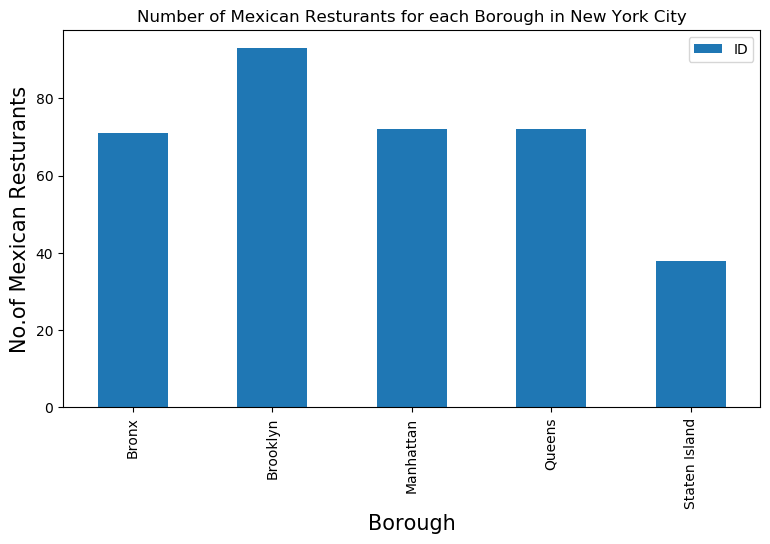

In [11]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Mexican Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Mexican Resturants', fontsize=15)
#giving a bar plot
mexican_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

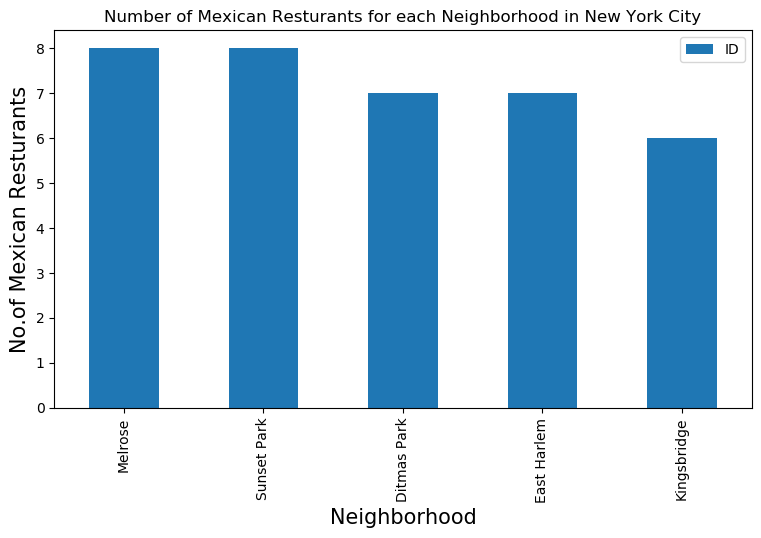

In [12]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Mexican Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Mexican Resturants', fontsize=15)
#giving a bar plot
mexican_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [13]:
# prepare neighborhood list that contains mexican resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
mexican_rest_stats_ny=pd.DataFrame(columns=column_names)
count=301


for row in mexican_rest_ny.values.tolist()[300:339]:
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(mexican_rest_ny),')','processed')
    mexican_rest_stats_ny = mexican_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                          Name  Likes  Rating  Tips
0  4b46a46ef964a5201d2626e3  Xochimilco Family Restaurant     35     8.8     8
( 301 / 338 ) processed
                         ID                    Name  Likes  Rating  Tips
0  58d3f7f79435a92450b97b0d  Chipotle Mexican Grill      3     7.2     0
( 302 / 338 ) processed
                         ID           Name  Likes  Rating  Tips
0  5591837d498ee4167d48bb73  Cinco de Mayo      8     6.9     3
( 303 / 338 ) processed
                         ID                 Name  Likes  Rating  Tips
0  4c520e0a9d642d7fd10593de  La Perla Restaurant     12     7.5     8
( 304 / 338 ) processed
                         ID           Name  Likes  Rating  Tips
0  42a4e380f964a520f7241fe3  Rosa Mexicano    210     8.6    70
( 305 / 338 ) processed
                         ID        Name  Likes  Rating  Tips
0  5d727f5ec0300e0008d4d76d  Tacovision     13     8.3     7
( 306 / 338 ) processed
                         ID       

In [15]:
mexican_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Concourse Village,4b46a46ef964a5201d2626e3,Xochimilco Family Restaurant,35,8.8,8
1,Bronx,Concourse Village,58d3f7f79435a92450b97b0d,Chipotle Mexican Grill,3,7.2,0
2,Bronx,Concourse Village,5591837d498ee4167d48bb73,Cinco de Mayo,8,6.9,3
3,Bronx,Concourse Village,4c520e0a9d642d7fd10593de,La Perla Restaurant,12,7.5,8
4,Manhattan,Sutton Place,42a4e380f964a520f7241fe3,Rosa Mexicano,210,8.6,70


I needed to do this 7 day with different restaurants because the free Foursquare account only allowed to get the values of 50 restaurant in 1 day

I saved all the information of all the restaurants in an csv file

In [18]:
mexican_rest_stats_ny_csv=pd.read_csv('mexican_rest_stats_complete.csv',encoding='latin-1')

In [19]:
mexican_rest_stats_ny_csv.shape

(338, 7)

In [20]:
mexican_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,5c47a4b21953f3002c558218,Chipotle Mexican Grill,1,7.6,0
1,Bronx,Co-op City,58582b156431e554e165d909,Moe's Southwest Grill,1,6.6,0
2,Bronx,Fieldston,0,0,0,0.0,0
3,Bronx,Fieldston,523f6e14498ef6fdefc0d690,Burrito Shop,10,7.1,4
4,Bronx,Fieldston,4b78ba71f964a5209fdf2ee3,Santa Fe Grill & Bar,11,6.9,17


In [21]:
mexican_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 7 columns):
Borough         338 non-null object
Neighborhood    338 non-null object
ID              338 non-null object
Name            338 non-null object
Likes           338 non-null int64
Rating          338 non-null float64
Tips            338 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 18.6+ KB


In [22]:
mexican_rest_stats_ny_csv['Likes']=mexican_rest_stats_ny_csv['Likes'].astype('float64')
mexican_rest_stats_ny_csv['Tips']=mexican_rest_stats_ny_csv['Tips'].astype('float64')

In [23]:
mexican_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 7 columns):
Borough         338 non-null object
Neighborhood    338 non-null object
ID              338 non-null object
Name            338 non-null object
Likes           338 non-null float64
Rating          338 non-null float64
Tips            338 non-null float64
dtypes: float64(3), object(4)
memory usage: 18.6+ KB


### Most liked restaurants

In [24]:
mexican_rest_stats_ny_csv.iloc[mexican_rest_stats_ny_csv['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              431e2d80f964a52079271fe3
Name                          La Esquina
Likes                               1990
Rating                               8.8
Tips                                 720
Name: 182, dtype: object

### Resturant with maximum rating

In [25]:
mexican_rest_stats_ny_csv.iloc[mexican_rest_stats_ny_csv['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                 Parkchester
ID              4b4929d2f964a520656826e3
Name                   Taqueria Tlaxcali
Likes                                131
Rating                               9.2
Tips                                  73
Name: 47, dtype: object

### Resturant with maximum tips

In [26]:
mexican_rest_stats_ny_csv.iloc[mexican_rest_stats_ny_csv['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              431e2d80f964a52079271fe3
Name                          La Esquina
Likes                               1990
Rating                               8.8
Tips                                 720
Name: 182, dtype: object

### Neigborhoods with the better rating average

In [27]:
ny_neighborhood_stats=mexican_rest_stats_ny_csv.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
104,Noho,9.050000
40,East Village,9.000000
50,Flatiron,9.000000
86,Lower East Side,8.833333
83,Little Italy,8.800000
155,West Village,8.800000
133,Soho,8.800000
65,Greenwich Village,8.800000
159,Windsor Terrace,8.800000
21,Chinatown,8.750000


### Average rating of Mexican Resturants for each Borough.

In [28]:
ny_borough_stats=mexican_rest_stats_ny_csv.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.125676
1,Brooklyn,7.391209
3,Queens,7.325714
0,Bronx,6.834286
4,Staten Island,6.048485


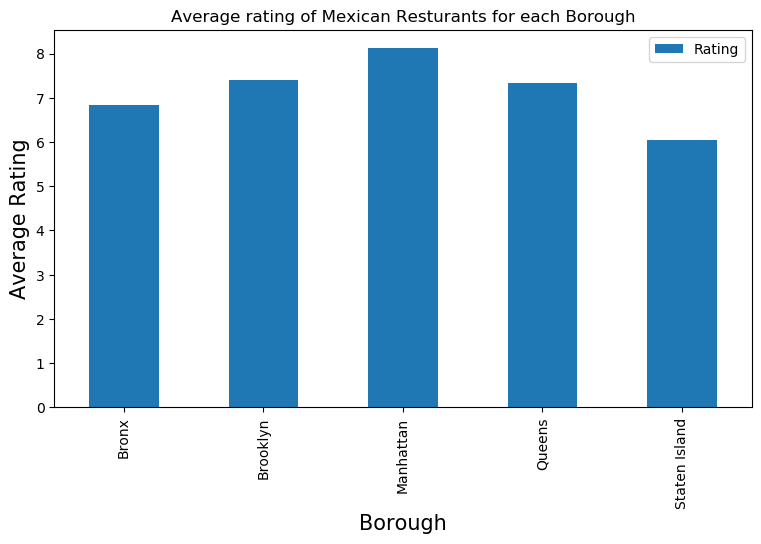

In [29]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Mexican Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
mexican_rest_stats_ny_csv.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Map on all the neighborhoods with average rating greater or equal 8.8

In [30]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.8]
ny_neighborhood_stats

,Neighborhood,Average Rating
40,East Village,9.000000
50,Flatiron,9.000000
65,Greenwich Village,8.800000
83,Little Italy,8.800000
86,Lower East Side,8.833333
104,Noho,9.050000
133,Soho,8.800000
155,West Village,8.800000
159,Windsor Terrace,8.800000


In [31]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [32]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,East Village,40.727847,-73.982226,9.000000
1,Manhattan,Flatiron,40.739673,-73.990947,9.000000
2,Manhattan,Greenwich Village,40.726933,-73.999914,8.800000
3,Manhattan,Little Italy,40.719324,-73.997305,8.800000
4,Manhattan,Lower East Side,40.717807,-73.980890,8.833333
5,Manhattan,Noho,40.723259,-73.988434,9.050000
6,Manhattan,Soho,40.722184,-74.000657,8.800000
7,Manhattan,West Village,40.734434,-74.006180,8.800000
8,Brooklyn,Windsor Terrace,40.656946,-73.980073,8.800000


In [33]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [34]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='green',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [35]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [36]:

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [40]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'BoroughBoundaries.json'

map = ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

### Conclusion

#### Answering the questions:
1. What are best location in New York City for Mexican Food?
##### A= East Village, Flatiron, Noho are some examples and most of the top rating neghborhoods are in Manhattan :D


2. Which areas have potential Mexican Restaurant Market?
##### A= Most of the top rating neghborhoods are in Manhattan and also in average Manhattan win


3. Which all areas lack Mexican Restaurants?
##### A= Staten Island is the last in average rating of Mexican Resturants.


4. Which is the best place to stay if you prefer Mexican Food?
##### A= Brooklyn is a good option with the most Mexican Restaurant but the best ranked Mexican Restaurants are in Manhattan